# Metal-Archives reviews - Part 1: Exploratory analysis

## Module imports

In [1]:
import re
import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('seaborn')
import seaborn as sns
sns.set(font_scale=2)

from nltk.corpus import stopwords

## Dataset

In [2]:
pd.options.display.float_format = "{:.2f}".format
df = pd.read_csv("E:/Projects/metallyrics/data/new/reviews.csv")

df['review_score'] = df['review_title'].str.extract('(\d+)\%$', expand=False).astype(int)

months = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']

def get_review_date(x):
    month, day, year = x.split()
    month = int(months.index(month)) + 1
    day = int(day[:-3])
    year = int(year)
    return datetime.date(year=year, month=month, day=day)

df['review_date'] = pd.to_datetime(df['review_date'].apply(get_review_date))

df = df[df['review_date'] < '2022']

The dataset consists of nearly 86,000 album reviews extracted from Metal-Archives (MA).
Each review is comprised of a block of text and a score ranging from 0 to 100.
The reviews cover about 35,000 albums produced by over 18,000 bands.

In [3]:
print("Reviews:", len(df))
print("Albums:", len(df.groupby(['band_name', 'album_name']).first()))
print("Bands:", len(set(df['band_name'])))

Reviews: 85934
Albums: 34548
Bands: 18065


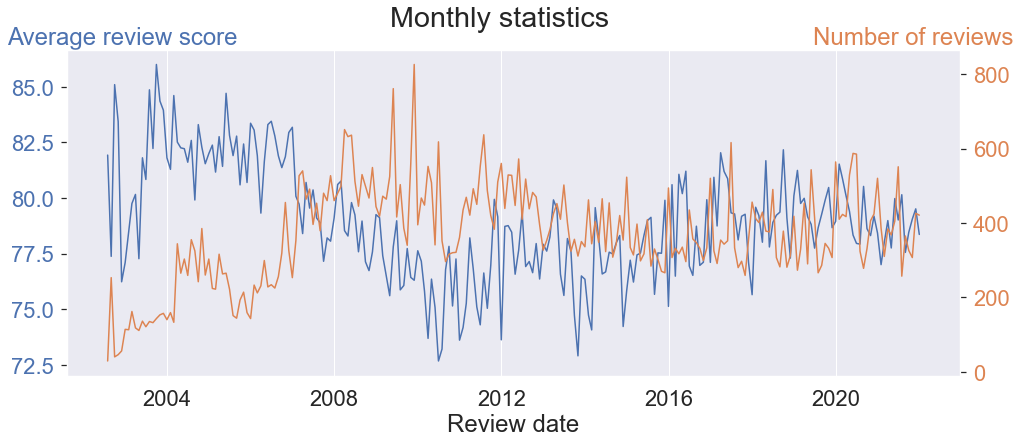

In [4]:
ts_rev_score = df.groupby(pd.Grouper(key='review_date', freq='M'))['review_score'].mean()
ts_rev_num = df.groupby(pd.Grouper(key='review_date', freq='M')).apply(len)
fig, ax1 = plt.subplots(1, 1, figsize=(16, 6))
fig.suptitle("Monthly statistics")
line1, = ax1.plot(ts_rev_score)
color1 = line1.get_color()
ax1.set_xlabel("Review date")
ax1.set_ylabel("Average review score", rotation=0, ha='left', va='bottom', y=1, color=color1)
[t.set_color(color1) for t in ax1.yaxis.get_ticklabels()]
ax1.grid(False, axis='y')
ax2 = ax1.twinx()
line2, = ax1.plot([], [])
color2 = line2.get_color()
ax2.plot(ts_rev_num, color=color2)
[t.set_color(color2) for t in ax2.yaxis.get_ticklabels()]
ax2.set_ylabel("Number of reviews", rotation=0, ha='right', va='bottom', y=1, color=color2)
ax2.grid(False)
plt.show()

Review traffic peaked around 2010 after a healthy rise throughout MA's early years.
Although the monthly rate has dropped since then, it's held rather steadily since.

In [5]:
print(f"average album review: {df['album_review_avg'].mean():.1f}")
print(f"median album review: {df['album_review_avg'].median():.1f}")
print(f"average number of reviews: {df['album_review_num'].mean():.1f}")
print(f"highest number of reviews: {df['album_review_num'].max():}")

average album review: 78.5
median album review: 81.0
average number of reviews: 6.6
highest number of reviews: 44


In [6]:
df['review_score'].value_counts().sort_index().cumsum() / len(df['review_score'])

0     0.00
1     0.01
2     0.01
3     0.01
4     0.01
      ... 
96    0.89
97    0.91
98    0.93
99    0.94
100   1.00
Name: review_score, Length: 101, dtype: float64

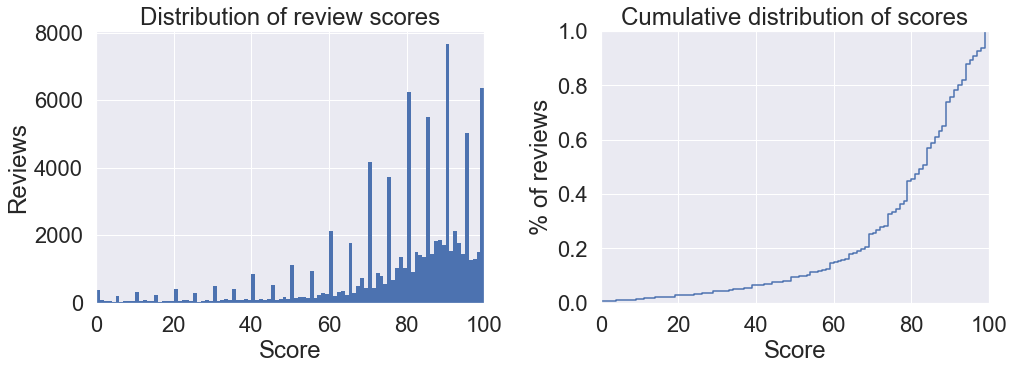

In [7]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 5))
fig.subplots_adjust(wspace=0.3)
df['review_score'].hist(ax=ax1, bins=range(101), linewidth=0)
ax1.set_title("Distribution of review scores")
ax1.set_xlabel("Score")
ax1.set_ylabel("Reviews")
ax1.set_xlim(0, 100)
score_cdf = df['review_score'].value_counts().sort_index().cumsum() / len(df['review_score'])
ax2.step(score_cdf.index, score_cdf.values)
ax2.set_title("Cumulative distribution of scores")
ax2.set_xlabel("Score")
ax2.set_ylabel("% of reviews")
ax2.set_xlim(0, 100)
ax2.set_ylim(0, 1)
plt.show()

The distribution of scores is very top-heavy, with an average of 78.5% and median of 81%.
There are peaks in the distribution at multiples of ten and five because reviewers often round out their scores.
Over a fifth of the reviews gave scores of at least 95%, and nearly a tenth of reviews gave a full 100%.

## Split dataset by album, band, genre, and country

In [8]:
def process_genre(genre):
    # Find words (including hyphenated words) not in parentheses
    out = re.findall('[\w\-]+(?![^(]*\))', genre.lower())
    stop_words = stopwords.words('english')
    out = [s for s in out if (s != 'metal' and s not in stop_words)]
    return out

all_genres = df['band_genre'].apply(process_genre)
genres = sorted(set(all_genres.sum()))
new_cols = {'genre_' + genre: all_genres.apply(lambda x: int(genre in x)) for genre in genres}
df = df.join(pd.DataFrame(new_cols))
print(df.columns)

Index(['band_name', 'band_id', 'band_url', 'band_country_of_origin',
       'band_location', 'band_status', 'band_formed_in', 'band_genre',
       'band_lyrical_themes', 'band_last_label',
       ...
       'genre_trance', 'genre_tribal', 'genre_trip', 'genre_trip-hop',
       'genre_vaporwave', 'genre_various', 'genre_viking', 'genre_wave',
       'genre_world', 'genre_yiddish'],
      dtype='object', length=169)


#### By album

In [9]:
df_albums = df[df.columns[df.columns.str.match('^(band_|album_|genre_)')]].groupby(['band_name', 'album_name']).first()
df_albums['album_review_avg'] = df.groupby(['band_name', 'album_name'])['review_score'].mean()
df_albums['album_review_std'] = df.groupby(['band_name', 'album_name'])['review_score'].std()
df_albums['album_review_num'] = df.groupby(['band_name', 'album_name']).apply(len)
df_albums.reset_index(inplace=True)
df_albums.rename(
    columns={c: re.sub(r"^(album_)", "", c) for c in df_albums.columns if re.match(r"^(album_)", c)},
    inplace=True
)
print(df_albums.columns)

Index(['band_name', 'name', 'band_id', 'band_url', 'band_country_of_origin',
       'band_location', 'band_status', 'band_formed_in', 'band_genre',
       'band_lyrical_themes',
       ...
       'genre_tribal', 'genre_trip', 'genre_trip-hop', 'genre_vaporwave',
       'genre_various', 'genre_viking', 'genre_wave', 'genre_world',
       'genre_yiddish', 'review_std'],
      dtype='object', length=165)


In [10]:
len(df_albums)

34548

#### Most-reviewed albums

In [11]:
df_albums[['band_name', 'name', 'band_genre', 'year', 'review_avg', 'review_num']].sort_values('review_num', ascending=False).reset_index(drop=True).shift(1).loc[1:10].convert_dtypes()

,band_name,name,band_genre,year,review_avg,review_num
1,Slayer,Reign in Blood,Thrash Metal,1986,84.75,44
2,Iron Maiden,Iron Maiden,"Heavy Metal, NWOBHM",1980,85.58,40
3,Metallica,Master of Puppets,Thrash Metal (early); Hard Rock (mid); Heavy/T...,1986,80.64,39
4,Mayhem,De Mysteriis Dom Sathanas,Black Metal,1994,88.26,38
5,Iron Maiden,The Number of the Beast,"Heavy Metal, NWOBHM",1982,86.55,38
6,Megadeth,Rust in Peace,Speed/Thrash Metal (early/later); Heavy Metal/...,1990,92.31,36
7,Black Sabbath,13,Heavy/Doom Metal,2013,67.81,36
8,Wintersun,Time I,Symphonic Melodic Death Metal,2012,68.39,36
9,Metallica,Ride the Lightning,Thrash Metal (early); Hard Rock (mid); Heavy/T...,1984,93.37,35
10,Megadeth,Countdown to Extinction,Speed/Thrash Metal (early/later); Heavy Metal/...,1992,77.06,35


#### By band

In [12]:
df_bands = df[df.columns[df.columns.str.match('^(band_|album_|genre_)')]].groupby('band_name').first()
df_bands['band_review_avg'] = df.groupby('band_name')['review_score'].mean()
df_bands['band_review_std'] = df.groupby('band_name')['review_score'].std()
df_bands['band_review_num'] = df.groupby('band_name').apply(len)
df_bands.reset_index(inplace=True)
df_bands.rename(
    columns={c: re.sub(r"^(band_)", "", c) for c in df_bands.columns if re.match(r"^(band_)", c)},
    inplace=True
)
df_bands['years_active'] = df_bands['years_active'].str.extractall(r'(\d{4,7})-(\d{4,7}|present)').apply('-'.join, axis=1).reset_index().groupby('level_0')[0].apply(','.join)
print(df_bands.columns)

Index(['name', 'id', 'url', 'country_of_origin', 'location', 'status',
       'formed_in', 'genre', 'lyrical_themes', 'last_label',
       ...
       'genre_trip-hop', 'genre_vaporwave', 'genre_various', 'genre_viking',
       'genre_wave', 'genre_world', 'genre_yiddish', 'review_avg',
       'review_std', 'review_num'],
      dtype='object', length=167)


In [13]:
len(df_bands)

18065

#### Bands with most reviews

In [14]:
df_bands[['name', 'genre', 'review_avg', 'review_num']].sort_values('review_num', ascending=False).reset_index(drop=True).shift(1).loc[1:10].convert_dtypes()

,name,genre,review_avg,review_num
1,Iron Maiden,"Heavy Metal, NWOBHM",80.94,480
2,Black Sabbath,Heavy/Doom Metal,81.99,388
3,Megadeth,Speed/Thrash Metal (early/later); Heavy Metal/...,74.94,357
4,Judas Priest,Heavy Metal,78.94,328
5,Darkthrone,Death Metal (early); Black Metal (mid); Black/...,79.47,289
6,Metallica,Thrash Metal (early); Hard Rock (mid); Heavy/T...,72.11,281
7,Slayer,Thrash Metal,74.72,273
8,Overkill,"Thrash Metal, Thrash/Groove Metal",79.04,248
9,Opeth,"Progressive Death Metal, Progressive Rock",78.55,244
10,Cannibal Corpse,Death Metal,80.31,232


#### By genre

This split is a little different from the rest because there can be multiple genres per row.

In [15]:
genre_dfs = {}
for genre in genres:
    genre_dfs[genre] = df[df['genre_' + genre] > 0]
df_genres = pd.DataFrame(index=pd.Series(genres, name='genre'))
for genre, genre_df in genre_dfs.items():
    df_genres.loc[genre, 'review_avg'] = genre_df['review_score'].mean()
    df_genres.loc[genre, 'review_std'] = genre_df['review_score'].std()
    df_genres.loc[genre, 'review_num'] = len(genre_df)
print(df_genres.columns)

Index(['review_avg', 'review_std', 'review_num'], dtype='object')


#### Genres with most reviews

In [16]:
df_genres[['review_avg', 'review_num']].sort_values('review_num', ascending=False).reset_index().shift(1).loc[1:10].convert_dtypes()

,genre,review_avg,review_num
1,death,78.53,27520
2,black,79.20,22283
3,thrash,77.42,14533
4,heavy,78.56,12576
5,power,78.62,11539
6,progressive,81.11,9355
7,doom,81.45,8923
8,melodic,76.99,8519
9,rock,77.07,7325
10,speed,79.41,4675


#### By country of origin

In [17]:
df_countries = df[df.columns[df.columns.str.match('^(band_|album_|genre_)')]].groupby('band_country_of_origin').first()
df_countries['album_num'] = df_albums.groupby('band_country_of_origin').size()
df_countries['band_num'] = df_bands.groupby('country_of_origin').size()
df_countries['review_avg'] = df.groupby('band_country_of_origin')['review_score'].mean()
df_countries['review_std'] = df.groupby('band_country_of_origin')['review_score'].std()
df_countries['review_num'] = df.groupby('band_country_of_origin').apply(len)
df_countries.reset_index(inplace=True)
df_countries.rename(columns={'band_country_of_origin': 'country_of_origin'}, inplace=True)
print(df_countries.columns)

Index(['country_of_origin', 'band_name', 'band_id', 'band_url',
       'band_location', 'band_status', 'band_formed_in', 'band_genre',
       'band_lyrical_themes', 'band_last_label',
       ...
       'genre_various', 'genre_viking', 'genre_wave', 'genre_world',
       'genre_yiddish', 'album_num', 'band_num', 'review_avg', 'review_std',
       'review_num'],
      dtype='object', length=169)


#### Countries with most reviews

In [18]:
df_countries[['country_of_origin', 'review_avg', 'review_num']].sort_values('review_num', ascending=False).reset_index(drop=True).shift(1).loc[1:10].convert_dtypes()

,country_of_origin,review_avg,review_num
1,United States,77.49,25433
2,Sweden,78.82,8095
3,Germany,78.58,7745
4,United Kingdom,79.56,6760
5,Finland,78.32,4617
6,Norway,79.56,4398
7,Canada,78.67,3417
8,Italy,76.47,2571
9,France,79.24,2292
10,Netherlands,79.43,1775


## Weighted-average album score

Comparing albums by simply looking at average review ratings fails to consider each album's popularity (or infamy).
This is important when the number of reviews per album vary dramatically.
Just like looking at product reviews, we naturally assign more weight to album review scores
that are averaged from the experiences of many people.

As you can see below, there are plenty of albums on MA with only a single, 100% review.
It doesn't make much sense to say these albums are all better than the most popular albums.
Likewise, there are plenty of albums with only a single 0% review.
The same can be seen when splitting the data by band.
I could apply a minimum number of reviews required to consider an album's review score legitimate,
but this shrinks down the dataset considerably and still weighs albums near the cutoff number and
near the maximum equally.

Instead, I will use a weighted-average score that treats individual reviews for an album as "evidence"
that the album ought to deviate from the population mean (of 79%).
Ideally, this method would distinguish good albums based on them having many positive reviews, not just a handful.
Likewise, it should help us reveal which albums draw a consensus of disdain from the MA community.

In [19]:
df_albums.sort_values('review_avg', ascending=False)[['band_name', 'name', 'review_avg', 'review_num']].reset_index(drop=True).shift(1).loc[1:5].convert_dtypes()

,band_name,name,review_avg,review_num
1,Beldam,Still the Wretched Linger,100,1
2,The Extinct Dreams,Фрагменты вечности,100,1
3,Pestilent,Purgatory of Punishment,100,1
4,Ceremonial Castings,Cthulhu,100,2
5,Sorhin,Apokalypsens ängel,100,1


In [20]:
df_albums.sort_values('review_avg', ascending=True)[['band_name', 'name', 'review_avg', 'review_num']].reset_index(drop=True).shift(1).loc[1:5].convert_dtypes()

,band_name,name,review_avg,review_num
1,Patrons of the Rotting Gate,The Rose Coil,0,1
2,Lotus Circle,Bottomless Vales and Boundless Floods,0,1
3,Lost Souls,Fracture,0,2
4,Waverly Hills,The Nurse,0,1
5,Cloak of Displacement,This Is the Only Way,0,1


In [21]:
df_bands.sort_values('review_avg', ascending=False)[['name', 'review_avg', 'review_num']].reset_index(drop=True).shift(1).loc[1:5].convert_dtypes()

,name,review_avg,review_num
1,Pimentola,100,1
2,Sunken,100,1
3,Nebula,100,1
4,Dying Humanity,100,1
5,Dead Asylum,100,1


In [22]:
df_bands.sort_values('review_avg', ascending=True)[['name', 'review_avg', 'review_num']].reset_index(drop=True).shift(1).loc[1:5].convert_dtypes()

,name,review_avg,review_num
1,The Ungrateful,0,1
2,Seventh Army,0,1
3,AIAA 7,0,1
4,Killer Fox,0,1
5,Dismembered Engorgement,0,1


#### Rating albums using Bayesian-weighted averaging

Supposedly IMDb rates content using the following
[weighted averaging scheme](https://www.quora.com/How-does-IMDbs-rating-system-work):

$$ W_i = \frac{R_in_i + Cm}{n_i + m} $$

where $R_i$ and $n_i$ are average score and number of scores for a sample $i$
(a movie in the IMDb case, an album in our case),
$C = \sum_{i=1}^n R_i$ represents the average of the full collection of scores,
which I'll call the population mean,
and $m$ is a tunable threshold for the number of ratings required to be included in the Top-250 list (25,000).
(The page I linked uses $v$ for "votes" instead of $n$; I prefer this notation.)
The issue with this is that it does depend on our choice of $m$,
which would have to be tailored to the dataset.
One way to pick it is to choose some percentile of the album review count distribution.
Choosing a high percentile would give a higher number for $m$,
weighing the second term in the numerator more heavily.
This effectively gives more weight to the number of reviews,
since a larger $n_i$ is required to pull $W_i$ away from the population mean $C$.
The choice of $m$ therefore matters a lot, but it's chosen subjectively.
Ideally we should be weighing the population term in a way that reflects
how confident we are that the population mean describes individual samples.

This weighted averaging is inspired by Bayesian statistics:
the population parameter $C$ represents a prior belief about an album's true score,
and the weighted average updates that prior based on the observations $R_i n_i$.
We can define a weighted average more rigourously if we fully adopt a Bayesian framework.
Note that the album scores are distributed within the range 0-100,
much like probabilities of a binary process (e.g. flipping a coin).
Let's say an album has some "true" score that the reviewers are estimating,
like people guessing how likely a flipped coin will land on heads.
We might have some _prior_ belief about that how that coin might behave,
based on our understanding of how coins typically land.
We could then update that belief using our observations,
arriving at a _posterior_ estimate for the probability of landing heads.
In the case of the album reviews, the scores can be anywhere in the range 0-100,
rather than purely binary, but we'll see that it doesn't affect the math.
We can follow the classic example of determining the posterior distribution for a Beta-Bernoulli model,
in which we assume that the review scores for an album follow a Bernoulli distribution.

Let's describe the population distribution of scores using the
[Beta distribution](https://en.wikipedia.org/wiki/Beta_distribution),
using the population mean and variance to determine the appropriate $\alpha_0$ and $\beta_0$ parameters
(see the "mean and variance" section of the wiki page).
We can use this to represent our prior belief for the parameters of the model.
Importantly, the Beta distribution is the conjugate prior for the Bernoulli distribution,
meaning the posterior probability distribution is itself a Beta distribution.
The posterior for an album $i$ with $n_i$ reviews and an average rating of $R_i$
is a Beta distibution with the parameters

$$\alpha = s_i + \alpha_0$$
$$\beta = n_i - s_i + \beta_0$$

where $s_i$ is the number of sucessful trials (coins landing on heads),
which in our case is the average review rating times the number of reviews: $s_i = R_i n_i$.

The mean of a Beta distribution with parameters $\alpha$ and $\beta$ is given by

$$\mu = \frac{\alpha}{\alpha + \beta}$$

Thus we can define as our weighted-average score in terms of the sample and prior parameters:

$$\mu = \frac{R_i n_i + \alpha_0}{s_i + \alpha_0 + n_i - s_i + \beta_0}$$


$$\mu = \frac{R_i n_i + \alpha_0}{n_i + \alpha_0 + \beta_0}$$

Doing the same thing for the prior mean $\mu_0$ in terms of $\alpha_0$ and $\beta_0$, we get

$$\mu = \frac{R_i n_i + \mu_0 (\alpha_0 + \beta_0)}{n_i + (\alpha_0 + \beta_0)}$$

Look familiar? The prior mean is the same as the $C$ parameter in the IMDb average,
so the only difference between this formula and the other is that we now have a clear definition
for the $m$ parameter now: it's the sum of the Beta priors,
which are directly derived from the population mean and variance!

$$\alpha_0 + \beta_0 = \frac{1}{\sigma_0^2} \left(\mu_0 - \mu_0^2 - \sigma_0^2\right)$$

To be fair it's not obvious how this parameter behaves,
but generally speaking a more narrow distribution of reviews in the broad population would
yield a smaller variance $\sigma_0^2$, which has a similar effect to using a larger $m$ in the IMDb method.
This is the expected behavior; a small prior variance represents a more confident prior belief about the mean.
The key is that now we are allowing the prior variance to be based on the actual variance of the data,
rather than simply picking a number.

Implementing this is straightforward: we just have to compute the prior parameters from the full dataset,
then for each album use its average score and number of reviews to compute the parameters of the posterior distribution.
From the parameters we then compute the posterior mean and call that our weighted average.
Below are some examples of what the posteriors look like for some extreme examples
where clearly the weighted average favors/punishes large sample sizes.

In [23]:
from scipy.stats import beta

In [24]:
def beta_prior(x):
    mu = x.mean()
    var = x.std() ** 2
    a = mu * (mu * (1 - mu) / var - 1)
    b = (1 - mu) * (mu * (1 - mu) / var - 1)
    prior = beta(a, b)
    return prior


def beta_posteriors(data, prior):
    n = data['review_num']
    s = data['review_avg'] / 100 * n
    a_prior, b_prior = prior.args
    a_post = s + a_prior
    b_post = n - s + b_prior
    posts = [beta(a, b) for a, b in zip(a_post, b_post)]
    return posts

def weighted_scores(data, verbose=False):
    prior = beta_prior(data['review_avg'] / 100.)
    if verbose:
        print(f"Prior (alpha, beta) = ({prior.args[0]:.2f}, {prior.args[0]:.2f})")
        print(f"Prior weight = {sum(prior.args):.2f}")
    posteriors = beta_posteriors(data, prior)
    post_means = 100 * pd.Series([post.mean() for post in posteriors], index=data.index)
    return post_means

#### Examples

In these albums we can see the posterior probability distribution of each album compared to the prior,
which is simply the population un-weighted average score distribution fit to a Beta distribution.
The weighted average score is the mean of this posterior,
computed independently for each album.
Metallica's Ride the Lightning has a raw average (sample mean) of 94%,
which is less than the 100% of Nightmare's Cosmovision,
but the posterior mean of Ride the Lightning (91%) outranks that of Cosmovision (81%)
due to its much larger sample size.
Likewise, on the other side of the population mean,
St. Anger's 44% sample mean is better than the one 0% review of Boris' Warpath,
but the weighted average puts St. Anger at 49%, worse than Warpath's 67%.

(4.747008496965688, 1.3652282483740878) 6.112236745339776
Prior mean = 78%

Album: Metallica - Ride the Lightning
Sample mean = 93%
Sample size = 35
Posterior mean = 91%

Album: Metallica - St. Anger
Sample mean = 44%
Sample size = 33
Posterior mean = 49%

Album: Nightmare - Cosmovision
Sample mean = 100%
Sample size = 1
Posterior mean = 81%

Album: Boris - Warpath
Sample mean = 0%
Sample size = 1
Posterior mean = 67%


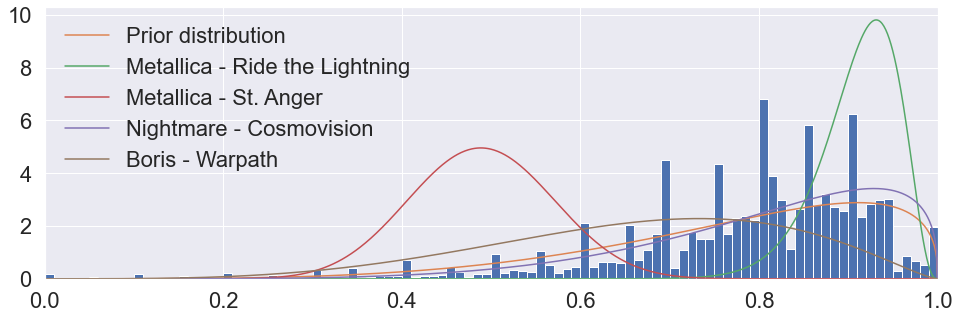

In [25]:
album_prior = beta_prior(df_albums['review_avg'] / 100.)
print(album_prior.args, sum(album_prior.args))
print(f"Prior mean = {100 * album_prior.mean():.0f}%")

album_posteriors = beta_posteriors(df_albums, album_prior)

x_plot = np.linspace(0, 1, 1000)
plt.figure(figsize=(16, 5))
plt.hist(df_albums['review_avg'] / 100., density=True, bins=100)
plt.plot(x_plot, album_prior.pdf(x_plot), label="Prior distribution")
plt.xlim(0, 1)

for name in ["Ride the Lightning", "St. Anger", "Cosmovision", "Warpath"]:
    i = df_albums.index[df_albums['name'] == name][0]
    post = album_posteriors[i]
    label = f"{df_albums.loc[i, 'band_name']} - {name}"
    print()
    print(f"Album: {label}")
    print(f"Sample mean = {df_albums.loc[i, 'review_avg']:.0f}%")
    print(f"Sample size = {df_albums.loc[i, 'review_num']:.0f}")
    print(f"Posterior mean = {100 * post.mean():.0f}%")
    plt.plot(x_plot, post.pdf(x_plot), label=label)

plt.legend()
plt.show()

The same effect of sample size is clearly seen when comparing bands
with high/low raw/weighted-average scores.

(5.262428537261289, 1.5654069394425087) 6.827835476703798
Prior mean = 77%

Band: Type O Negative
Sample mean = 91%
Sample size = 89
Posterior mean = 90%

Band: Waking the Cadaver
Sample mean = 34%
Sample size = 46
Posterior mean = 40%

Band: Gorement
Sample mean = 97%
Sample size = 10
Posterior mean = 89%

Band: Car Door Dick Smash
Sample mean = 4%
Sample size = 5
Posterior mean = 46%


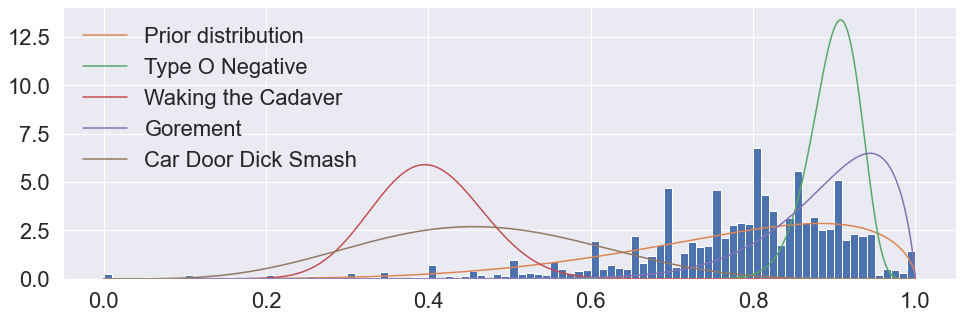

In [26]:
band_prior = beta_prior(df_bands['review_avg'] / 100.)
print(band_prior.args, sum(band_prior.args))
print(f"Prior mean = {100 * band_prior.mean():.0f}%")

band_posteriors = beta_posteriors(df_bands, band_prior)

plt.figure(figsize=(16, 5))
plt.hist(df_bands['review_avg'] / 100., density=True, bins=100)
plt.plot(x_plot, band_prior.pdf(x_plot), label="Prior distribution")

for name in ["Type O Negative", "Waking the Cadaver", "Gorement", "Car Door Dick Smash"]:
    i = df_bands.index[df_bands['name'] == name][0]
    post = band_posteriors[i]
    print()
    print(f"Band: {name}")
    print(f"Sample mean = {df_bands.loc[i, 'review_avg']:.0f}%")
    print(f"Sample size = {df_bands.loc[i, 'review_num']:.0f}")
    print(f"Posterior mean = {100 * post.mean():.0f}%")
    plt.plot(x_plot, post.pdf(x_plot), label=name)

plt.legend()
plt.show()

#### Apply weighted score to dataset

In [27]:
df_albums['review_weighted'] = weighted_scores(df_albums, verbose=True)
df_albums['review_weighted'].describe()

Prior (alpha, beta) = (4.75, 4.75)
Prior weight = 6.11


count   34548.00
mean       77.78
std         3.78
min        31.06
25%        76.59
50%        78.27
75%        79.68
max        93.81
Name: review_weighted, dtype: float64

In [28]:
df_bands['review_weighted'] = weighted_scores(df_bands, verbose=True)
df_bands['review_weighted'].describe()

Prior (alpha, beta) = (5.26, 5.26)
Prior weight = 6.83


count   18065.00
mean       77.29
std         3.54
min        33.52
25%        76.04
50%        77.70
75%        79.11
max        91.80
Name: review_weighted, dtype: float64

In [29]:
df_genres['review_weighted'] = weighted_scores(df_genres, verbose=True)
df_genres['review_weighted'].describe()

Prior (alpha, beta) = (18.42, 18.42)
Prior weight = 24.06


count   144.00
mean     76.94
std       3.72
min      65.89
25%      75.59
50%      77.20
75%      79.38
max      84.04
Name: review_weighted, dtype: float64

In [30]:
df_countries['review_weighted'] = weighted_scores(df_countries, verbose=True)
df_countries['review_weighted'].describe()

Prior (alpha, beta) = (21.88, 21.88)
Prior weight = 28.29


count   124.00
mean     77.92
std       1.97
min      69.22
25%      76.75
50%      77.76
75%      79.23
max      82.49
Name: review_weighted, dtype: float64

In [31]:
df_countries.to_csv("reviews_countries.csv", index=False)

#### Weighted score distribution

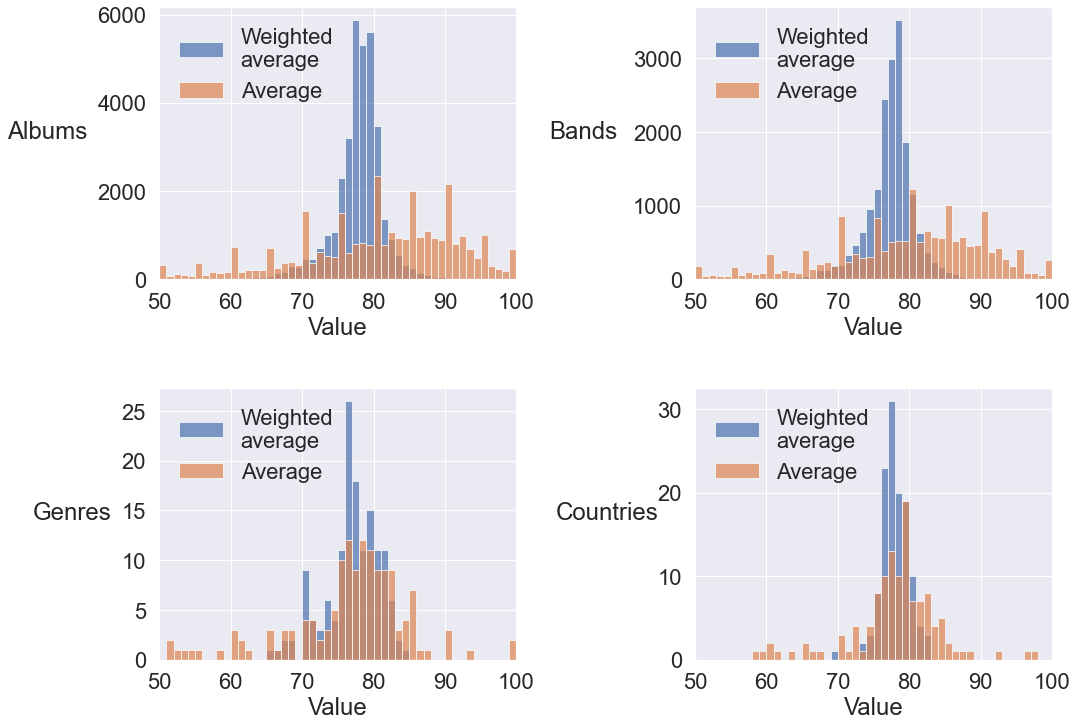

In [32]:
def plot_hist(data, ax, bins, ylabel):
    ax.hist(data['review_weighted'], bins=bins, alpha=0.7, label="Weighted\naverage")
    ax.hist(data['review_avg'], bins=bins, alpha=0.7, label="Average")
    ax.set_xlabel("Value")
    ax.set_ylabel(ylabel, rotation=0, labelpad=50)
    ax.set_xlim(50, 100)
    ax.legend(loc="upper left")


fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 12))
fig.subplots_adjust(wspace=0.5, hspace=0.4)

bins = 100
plot_hist(df_albums, ax1, np.linspace(0, 100, 101), "Albums")
plot_hist(df_bands, ax2, np.linspace(0, 100, 101), "Bands")
plot_hist(df_genres, ax3, np.linspace(0, 100, 101), "Genres")
plot_hist(df_countries, ax4, np.linspace(0, 100, 101), "Countries")

plt.show()

Looking at the histograms of the weighted average scores and raw average scores,
we can see that the weighted scores push most samples towards the population mean.
This is stronger when looking at albums since the sample sizes are generally smaller.
In the case of genres and countries, the effect is quite weak and probably
won't affect rankings too heavily.

#### Best and worst albums

In [33]:
review_cols = ['review_num', 'review_avg', 'review_weighted']

In [34]:
album_cols = ['band_name', 'name', 'year', 'band_genre'] + review_cols

In [35]:
df_albums[album_cols].sort_values('review_weighted', ascending=False).reset_index(drop=True).shift(1).loc[1:20].convert_dtypes()

,band_name,name,year,band_genre,review_num,review_avg,review_weighted
1,Entombed,Left Hand Path,1990,Death Metal/Death 'n' Roll,25,97.76,93.81
2,King Diamond,Abigail,1987,Heavy Metal,18,97.22,92.26
3,Katatonia,Dance of December Souls,1993,Doom/Death Metal (early); Gothic/Alternative/P...,22,95.45,91.59
4,Bolt Thrower,Realm of Chaos: Slaves to Darkness,1989,Death Metal,24,95.08,91.55
5,Symphony X,The Divine Wings of Tragedy,1996,Progressive Power Metal,17,96.53,91.54
6,Morbid Saint,Spectrum of Death,1990,Thrash Metal,23,95.00,91.36
7,Atheist,Unquestionable Presence,1991,Progressive Death/Thrash Metal with Jazz influ...,21,95.33,91.35
8,W.A.S.P.,The Crimson Idol,1992,Heavy Metal/Hard Rock,16,96.38,91.20
9,Suffocation,Effigy of the Forgotten,1991,Brutal/Technical Death Metal,23,94.78,91.19
10,Primordial,To the Nameless Dead,2007,Celtic Folk/Black Metal,13,97.54,91.18


The best album by weighted-average score is the 1990 death metal record
[Left Hand Path](https://en.wikipedia.org/wiki/Left_Hand_Path_(album)) by Entombed.
Most of the top-20 albums hail from the 80s and 90s, a testament to their reputations as heavy metal classics.
Primordial's [To the Nameless Dead](https://en.wikipedia.org/wiki/To_the_Nameless_Dead) and
Ahab's [The Call of the Wretched Sea](https://en.wikipedia.org/wiki/The_Call_of_the_Wretched_Sea)
are the only post-2000 albums that make the top twenty.

In [36]:
df_albums[album_cols].sort_values('review_weighted').reset_index(drop=True).shift(1).loc[1:20].convert_dtypes()

,band_name,name,year,band_genre,review_num,review_avg,review_weighted
1,Thrash or Die,Poser Holocaust,2011,Thrash Metal,14,10.71,31.06
2,Hellyeah,Hellyeah,2007,Groove Metal,13,10.69,32.11
3,Waking the Cadaver,Perverse Recollections of a Necromangler,2007,Slam/Brutal Death Metal/Deathcore (early); Dea...,33,25.45,33.61
4,Six Feet Under,Graveyard Classics 2,2004,"Death/Groove Metal, Death 'n' Roll",10,7.50,34.12
5,Massacre,Promise,1996,Death Metal,9,8.11,36.24
6,Grieving Age,Merely the Fleshless We and the Awed Obsequy,2013,Doom/Death Metal,6,0.83,39.60
7,Six Feet Under,Nightmares of the Decomposed,2020,"Death/Groove Metal, Death 'n' Roll",11,19.27,40.13
8,Morbid Angel,Illud Divinum Insanus,2011,Death Metal,30,35.43,42.58
9,Cryptopsy,The Unspoken King,2008,Brutal/Technical Death Metal,18,31.00,42.83
10,Skinlab,Revolting Room,2002,Groove Metal (early); Nu-Metal (later),6,8.00,43.15


At the other end of the rankings,
[Poser Holocaust](https://www.metal-archives.com/albums/Thrash_or_Die/Poser_Holocaust/307982)
by Thrash or Die earn the worst weighted score,
but Waking the Cadaver's debut album
[Perverse Recollections of a Necromangler](https://en.wikipedia.org/wiki/Perverse_Recollections_of_a_Necromangler)
deserves a mention for having a whopping 33 reviews:
it's amusing that more people have reviewed this record than have reviewed Ride the Lightning.
Maybe this just reflects on the sort of opinions album reviewers enjoy sharing...

Many of the bottom twenty albums actually come from otherwise highly respected artists whose fans simply expected better.
It almost seems like a rite of passage to disappoint your fans after a decade or two of consistent performance.
Next we'll look at which bands have done the best or worst over the full course of their careers.

#### Best and worst bands

In [37]:
band_cols = ['name', 'genre'] + review_cols

In [38]:
df_bands[band_cols].sort_values('review_weighted', ascending=False).reset_index(drop=True).shift(1).loc[1:20].convert_dtypes()

,name,genre,review_num,review_avg,review_weighted
1,Evoken,Funeral Doom/Death Metal,32,94.94,91.80
2,Acid Bath,Sludge/Doom Metal,27,95.07,91.44
3,Morbid Saint,Thrash Metal,27,93.70,90.35
4,Moonsorrow,Folk/Pagan/Black Metal,74,91.24,90.05
5,Intestine Baalism,Melodic Death Metal,19,94.63,89.99
6,Type O Negative,Gothic/Doom Metal,89,90.93,89.95
7,Demilich,Technical/Avant-garde Death Metal,26,93.04,89.72
8,Satan,"NWOBHM, Heavy Metal",28,92.39,89.39
9,Forefather,Black/Viking Metal,17,94.29,89.36
10,Angra,Power/Progressive Metal,83,90.25,89.25


To accumulate a high weighted-average score, a band must put out many albums,
each garnering many positive reviews.
Many of the most popular bands in metal do poorly in this sense,
as they set very high standards for themselves and almost always have one or two albums
that far underperform compared to the rest of their discography.
This leaves us with some surprise appearances at the top of the weighted-average rankings:
[Evoken](https://en.wikipedia.org/wiki/Evoken)
takes the crown for highest weighted score.
Over a six-album discography, they boast a minimum album rating of 91%.
There's quite a lot of variety among the top few bands,
with many different genres and nationalities being represented.

In [39]:
df_bands[band_cols].sort_values('review_weighted', ascending=True).reset_index(drop=True).shift(1).loc[1:20].convert_dtypes()

,name,genre,review_num,review_avg,review_weighted
1,Thrash or Die,Thrash Metal,16,14.94,33.52
2,Skinlab,Groove Metal (early); Nu-Metal (later),17,17.35,34.47
3,Hellyeah,Groove Metal,22,23.73,36.36
4,Waking the Cadaver,Slam/Brutal Death Metal/Deathcore (early); Dea...,46,34.46,39.96
5,Legion of Thor,Hardcore Punk/Metalcore (early); Death Metal/D...,7,3.86,40.01
6,Winds of Plague,Symphonic Deathcore,33,37.24,44.07
7,Animae Capronii,Black Metal,10,22.60,44.70
8,Grieving Age,Doom/Death Metal,8,18.75,45.61
9,Car Door Dick Smash,Thrash Metal/Grindcore,5,4.40,46.35
10,Aryan Terrorism,Black Metal,6,13.33,47.26


Yet again [Thrash or Die](https://en.wikipedia.org/wiki/Thrash_or_Die)
take up their position at the bottom of this ranking.
It's mostly due to that horrid debut album of theirs;
it makes up 14 of their 16 overall reviews.
Their 2015 follow-up album at least managed to get a couple of reviews over 40%...

#### Best and worst genres

In [40]:
df_genres[review_cols].sort_values('review_weighted', ascending=False).reset_index().shift(1).loc[1:10].convert_dtypes()

,genre,review_num,review_avg,review_weighted
1,eastern,142,85.31,84.04
2,middle,125,85.28,83.87
3,grunge,147,84.42,83.32
4,post-metal,564,82.59,82.34
5,epic,1358,82.42,82.32
6,dungeon,55,84.51,82.09
7,synth,55,84.51,82.09
8,funeral,734,82.23,82.05
9,fusion,133,82.99,82.01
10,jazz,139,82.88,81.95


Interestingly, Middle-Eastern metal (which gets split up into middle and eastern because of the genre tag parsing)
is rated very highly.
This chart has a lot of unexpected appearances,
and I'm not sure there's much to read into here.
When grouping by genres there are far more reviews per sample,
so the weighted averaging doesn't stray far from the raw average.

In [41]:
df_genres[review_cols].sort_values('review_weighted', ascending=True).reset_index().shift(1).loc[1:10].convert_dtypes()

,genre,review_num,review_avg,review_weighted
1,pop,83,62.80,65.89
2,nu-metal,534,65.94,66.40
3,deathcore,1007,66.88,67.11
4,acoustic,83,65.34,67.86
5,tribal,30,61.93,68.45
6,metalcore,1892,68.82,68.91
7,indie,18,61.44,70.09
8,groove,3703,70.12,70.16
9,cappella,16,60.94,70.32
10,cybergrind,12,58.25,70.47


At the bottom, no-one can be surprised to see pop taking the spot of loweset weighted reviews.
Metal purists are known for the dislike of most deathcore, metalcore, and nu-metal, and it shows here as well.

#### Best and worse countries

Similar to genres, the large sample sizes of most countries seems to
weaken the differences between the raw and weighted averages.
Nevertheless the weighting brings up some interesting contenders
for the best and worst countries when it comes to producing metal records.

In [42]:
country_cols = ['country_of_origin'] + review_cols

In [43]:
df_countries[country_cols].sort_values('review_weighted', ascending=False).reset_index(drop=True).shift(1).loc[1:10].convert_dtypes()

,country_of_origin,review_num,review_avg,review_weighted
1,Ireland,280,83.01,82.49
2,Iceland,140,83.47,82.44
3,Denmark,962,82.49,82.35
4,Andorra,28,86.64,81.96
5,Tunisia,29,85.76,81.60
6,Singapore,100,82.37,81.26
7,Japan,1102,81.28,81.18
8,Jordan,33,84.12,80.99
9,Faroe Islands,71,82.24,80.84
10,Georgia,16,87.00,80.82


In [44]:
df_countries[country_cols].sort_values('review_weighted', ascending=True).reset_index(drop=True).shift(1).loc[1:10].convert_dtypes()

,country_of_origin,review_num,review_avg,review_weighted
1,Saudi Arabia,21,58.29,69.22
2,Ecuador,15,66.67,73.64
3,Vietnam,9,63.33,73.95
4,Algeria,10,65.60,74.27
5,North Macedonia,8,65.00,74.61
6,Iraq,5,60.40,74.79
7,Unknown,50,73.70,75.01
8,Syria,12,70.00,75.15
9,Botswana,14,71.43,75.38
10,Nepal,17,72.41,75.48


## Geographic distribution of albums and genres

Now we'll look at some geographic numbers describing the popularity of metal around the world.

#### Countries of origin

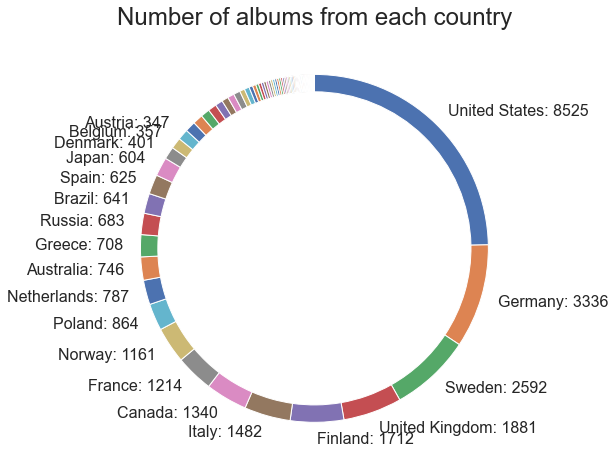

In [45]:
countries_num_albums = df_albums.groupby('band_country_of_origin').apply(len).sort_values(ascending=False)

fig, ax = plt.subplots(1, 1, figsize=(8, 8))
ax.pie(
    countries_num_albums.values,
    labels=[('{}: {}'.format(country, num_albums) if num_albums > 0.01 * countries_num_albums.sum() else '')
            for country, num_albums in countries_num_albums.items()],
    wedgeprops=dict(width=0.1),
    startangle=90,
    counterclock=False,
    textprops={'fontsize': 16},
)
ax.set_aspect('equal')
ax.set_title('Number of albums from each country')
plt.show()

The U.S. clearly dominates in album production (or at least the production of albums that are cataloged on MA;
although I'm quite confident the selection bias is not too strong considering how active the MA community is).
Most of the top countries in the scene are of course European.

#### U.S. states of origin

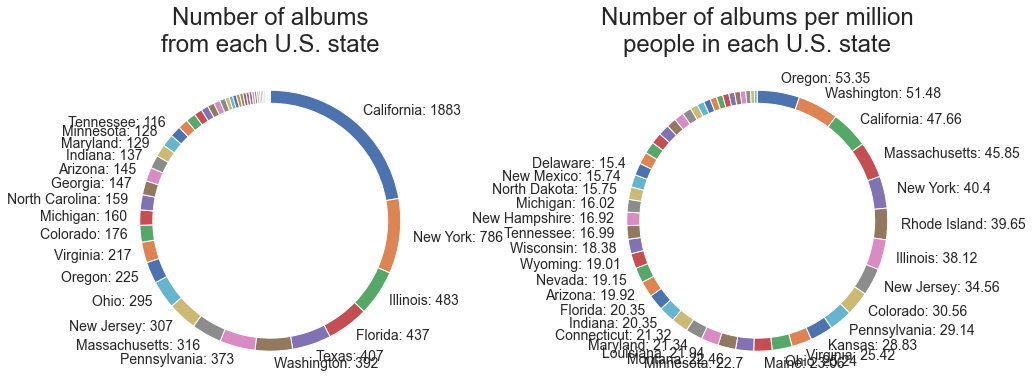

In [46]:
df_pops = pd.read_csv('../../data/state_population/2019_Census_US_Population_Data_By_State_Lat_Long.csv')
state_pops = pd.Series(df_pops['POPESTIMATE2019'].values, index=df_pops['STATE'].rename('state'))
df_usa = df_albums[df_albums['band_country_of_origin'] == 'United States'].copy()
pattern = '(' + '|'.join(state_pops.index) + ')'
df_usa['state'] = df_usa['band_location'].str.extract(pattern)
states_num_albums = df_usa.groupby('state').apply(len).sort_values(ascending=False)
states_num_albums_density = states_num_albums / state_pops * 1e6
states_num_albums_density = states_num_albums_density.fillna(0).round(2).sort_values(ascending=False)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
ax1.pie(
    states_num_albums.values,
    labels=[('{}: {}'.format(state, num_albums) if num_albums > 0.013 * states_num_albums.sum() else '')
            for state, num_albums in states_num_albums.items()],
    wedgeprops=dict(width=0.1),
    startangle=90,
    counterclock=False,
    textprops={'fontsize': 14},
)
ax1.set_aspect('equal')
ax1.set_title("Number of albums\nfrom each U.S. state")
ax2.pie(
    states_num_albums_density.values,
    labels=[('{}: {}'.format(state, num_albums) if num_albums > 0.015 * states_num_albums_density.sum() else '')
            for state, num_albums in states_num_albums_density.items()],
    wedgeprops=dict(width=0.1),
    startangle=90,
    counterclock=False,
    textprops={'fontsize': 14},
)
ax2.set_aspect('equal')
ax2.set_title("Number of albums per million\npeople in each U.S. state")
plt.show()

Within the U.S. itself, California produces the most metal albums,
followed by a few other high-population states.
Per capita, however, Oregon and Washington come out on top;
The Pacific Northwest weather is perfect for heavy metal after all.

#### Top countries in each genre

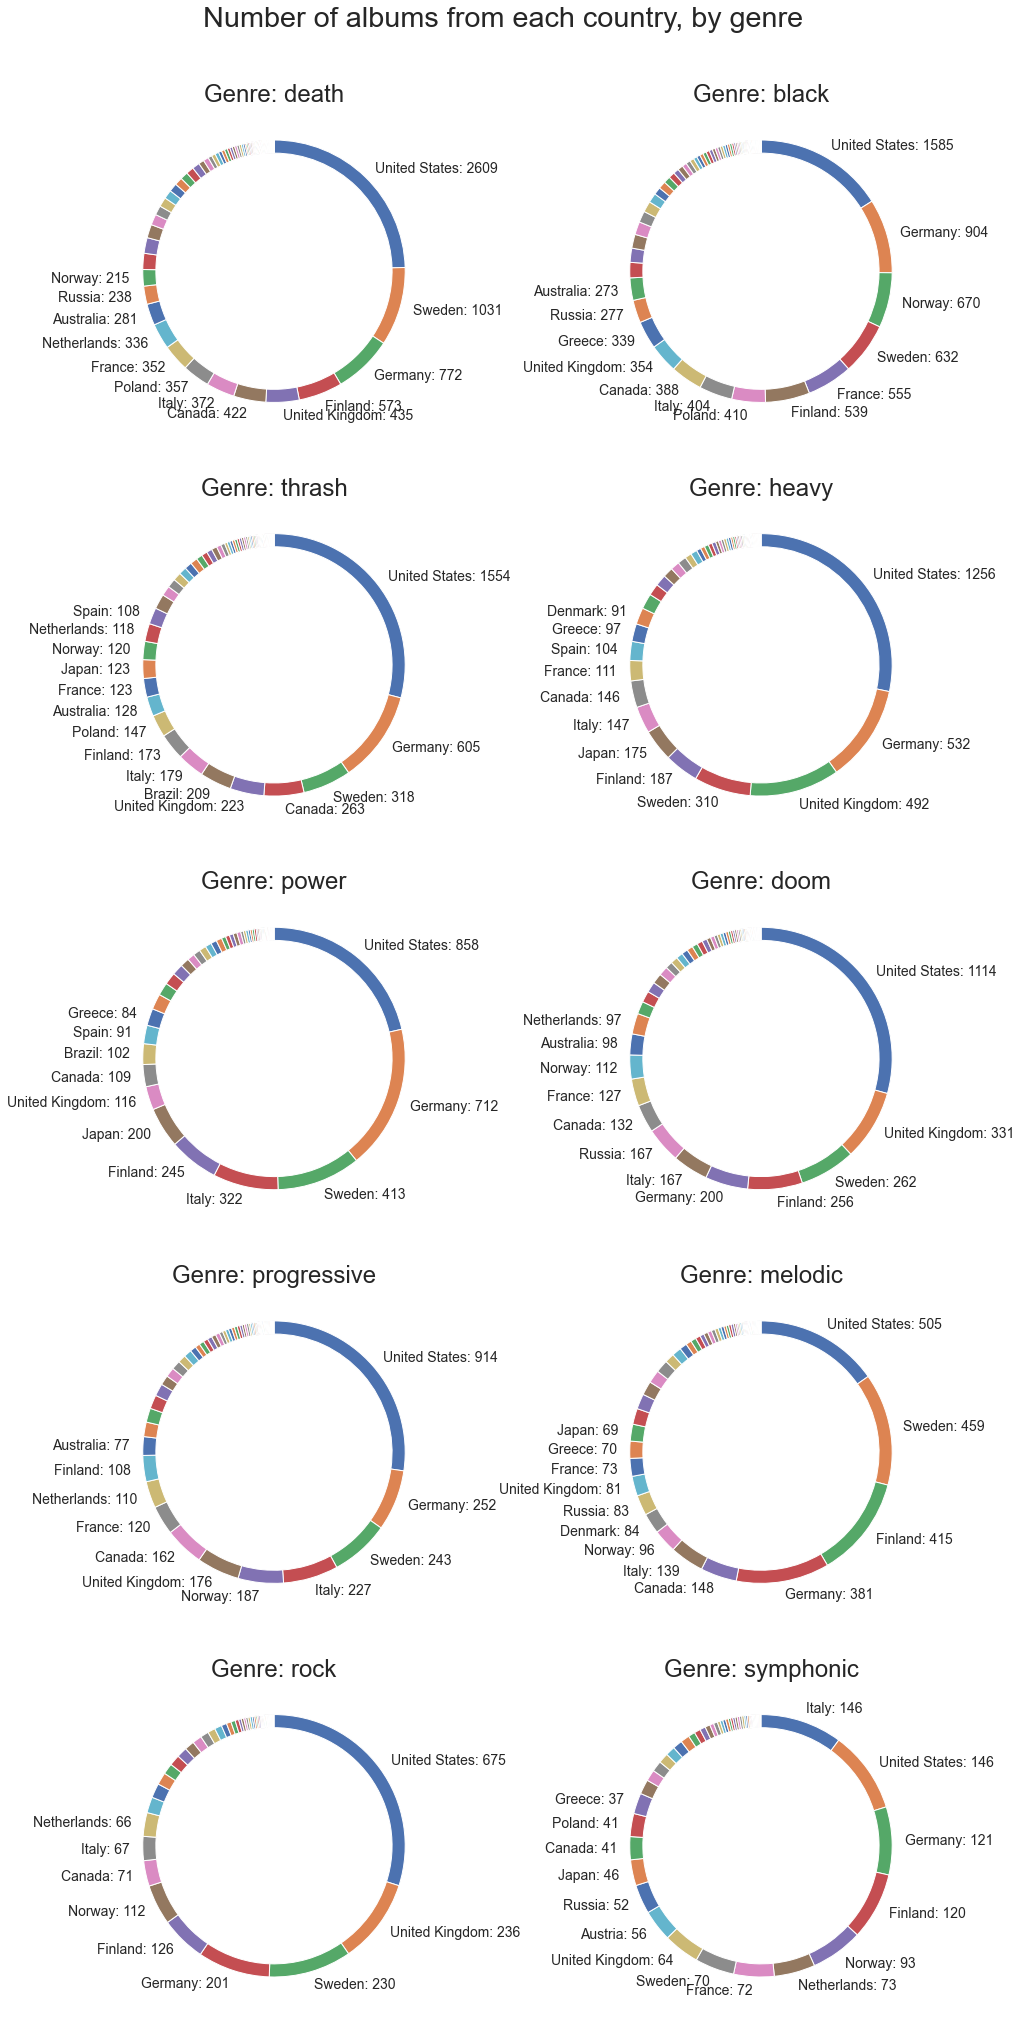

In [47]:
genres_num_albums = df_albums[[col for col in df_albums.columns if 'genre_' in col]].sum(0).sort_values(ascending=False)[:10]
fig, ax = plt.subplots(5, 2, figsize=(16, 35))
fig.suptitle("Number of albums from each country, by genre", y=0.92)
ax = ax.flatten()
for i, col in enumerate(genres_num_albums.index):
    countries_genre_num_albums = df_albums[df_albums[col] > 0].groupby('band_country_of_origin').apply(len).sort_values(ascending=False)
    ax[i].pie(
        countries_genre_num_albums.values,
        labels=[('{}: {}'.format(country, num_albums) if num_albums > 0.02 * countries_genre_num_albums.sum() else '')
                for country, num_albums in countries_genre_num_albums.items()],
        wedgeprops=dict(width=0.1),
        startangle=90,
        counterclock=False,
        textprops={'fontsize': 14},
    )
    ax[i].set_aspect('equal')
    ax[i].set_title(f'Genre: {col[6:]}')
plt.show()

The U.S. is still the top producer of albums in most genres,
but when it comes to the "melodic" genre tag,
which most often refers to melodic death metal in particular,
the Swedes and Finns contribute a large portion.
The Germans produce an notably large portion of power metal albums.

#### Top genres in each country

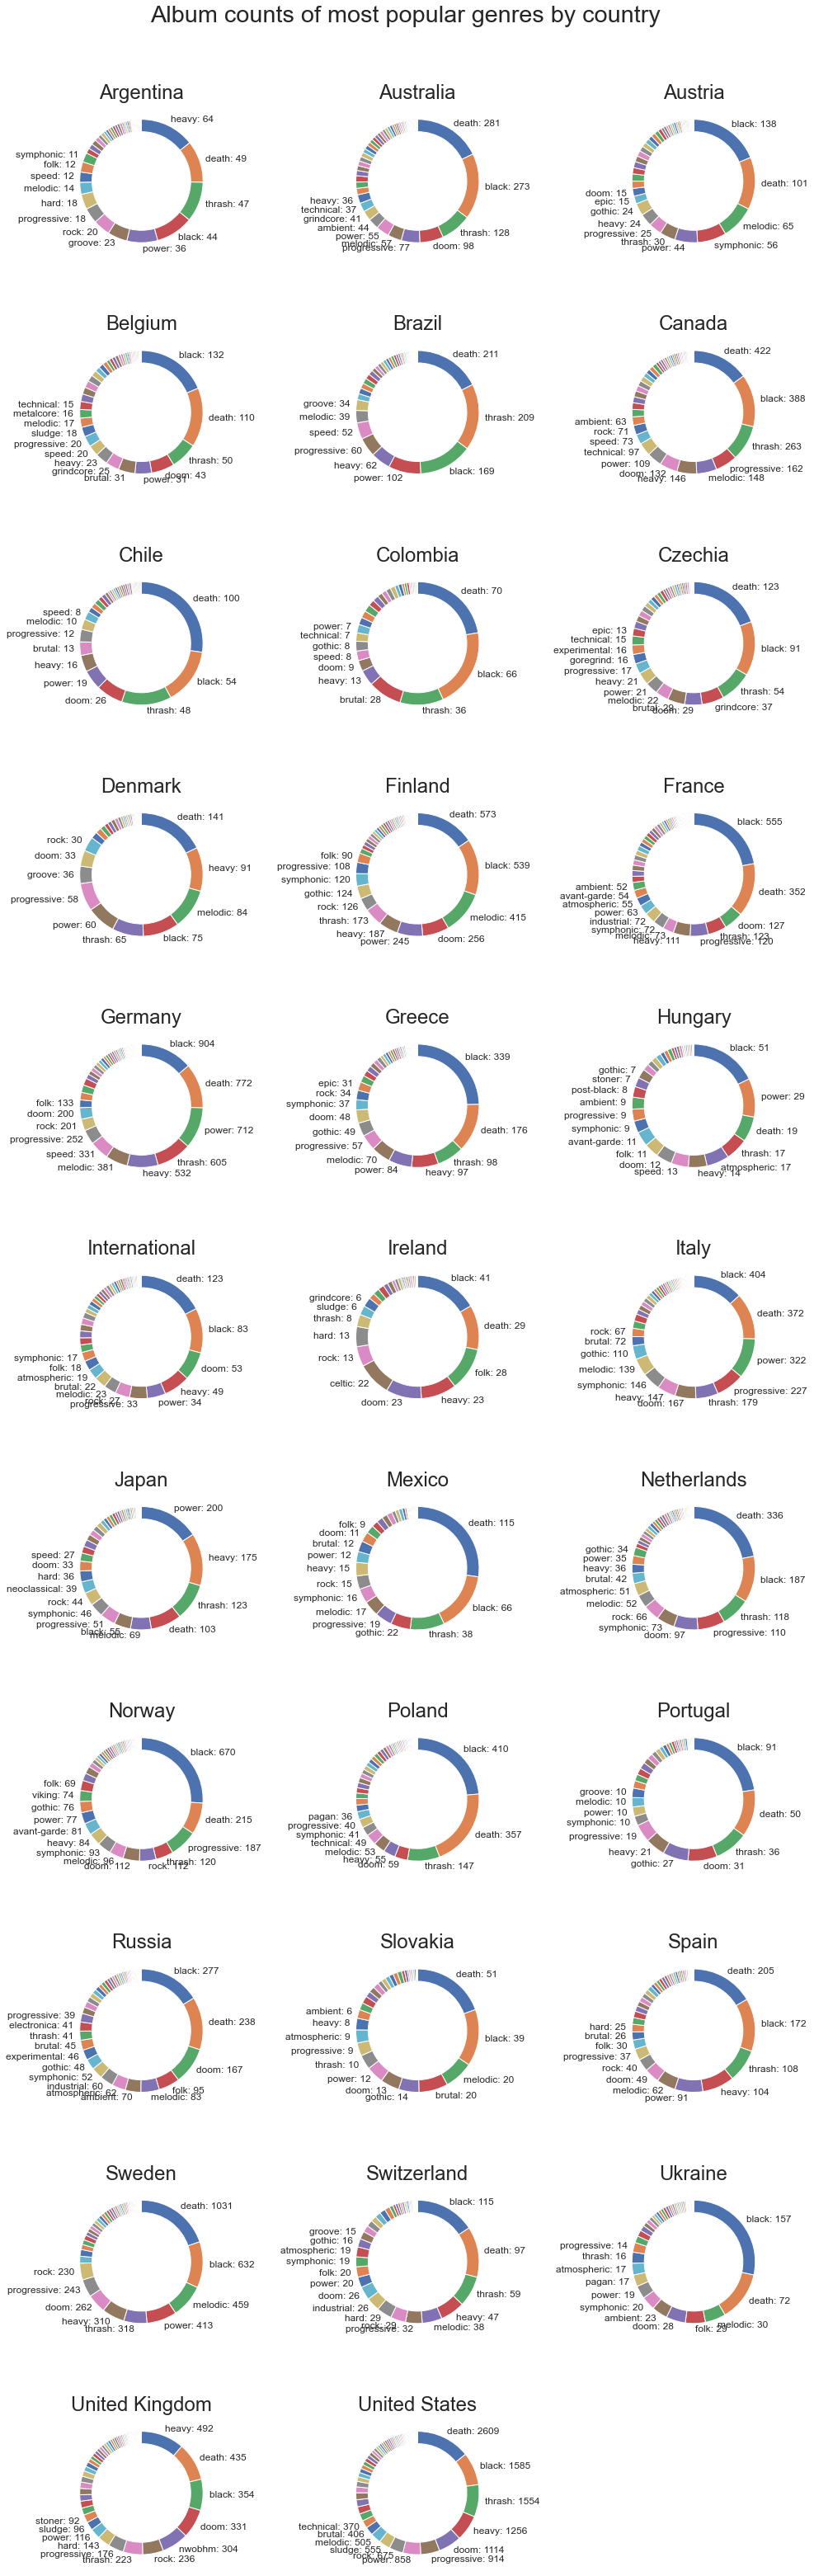

In [48]:
min_albums = 100
ncols = 3
country_albums = df_albums.groupby('band_country_of_origin').apply(len)
countries = country_albums[country_albums > min_albums].index
nrows = int(np.ceil(len(countries) / ncols))
fig, axes = plt.subplots(nrows, ncols, figsize=(16, 5 * nrows))
fig.subplots_adjust(hspace=0.5, wspace=0.5)
fig.suptitle("Album counts of most popular genres by country", y=0.91)
axes = axes.flatten()
for i, ax in enumerate(axes):
    if i >= len(countries):
        ax.set_axis_off()
        continue
    country = countries[i]
    df_country = df_albums[df_albums['band_country_of_origin'] == country]
    popular_genres = []
    albums_in_genre = []
    for genre in genres:
        num_albums = df_country['genre_' + genre].sum()
        popular_genres.append(genre)
        albums_in_genre.append(num_albums)
    x, y = [
        list(k[::-1]) for k in 
        zip(
            *sorted(
                zip(popular_genres, albums_in_genre),
                key=lambda pair: pair[1]
            )
        )
    ]
    ax.pie(
        y,
        labels=[('{}: {}'.format(country, num_albums) if num_albums > 0.02 * sum(y) else '')
                for country, num_albums in zip(x, y)],
        wedgeprops=dict(width=0.2),
        startangle=90,
        counterclock=False,
        textprops={'fontsize': 12},
    )
    ax.set_aspect('equal')
    ax.set_title(country)
plt.show()

For most countries, death and black metal are the most common genres.
The Ukranians seem to hold the strongest preference for a single genre,
with nearly a third of Ukranian albums coming from bands identified as black metal.
The largest stake power metal takes is in Germany,
while thrash surprisingly is most proportionately popular in Japan.

#### Export yearly national trends

* World population data sourced from https://population.un.org/wpp/Download/Standard/CSV/
* U.S. states population data scourced from https://www.census.gov/data/datasets/time-series/demo/popest/2010s-state-total.html

In [49]:
def band_active(s, year):
    if isinstance(s, str):
        for rng in s.split(','):
            a, b = rng.split('-')
            if b != 'present':
                if int(a) <= year <= int(b):
                    return True
            else:
                if year >= int(a):
                    return True
    return False

In [195]:
COUNTRIES_RENAME = {
    'Bolivia': 'Bolivia (Plurinational State of)',
    'Hong Kong': 'China, Hong Kong SAR',
    'Iran': 'Iran (Islamic Republic of)',
    'Korea, South': 'Republic of Korea',
    'Moldova': 'Republic of Moldova',
    'Russia': 'Russian Federation',
    'Syria': 'Syrian Arab Republic',
    'Taiwan': 'China, Taiwan Province of China',
    'United States': 'United States of America',
    'Venezuela': 'Bolivarian Republic of Venezuela',
    'Vietnam': 'Viet Nam',
}


def get_counts_per_capita(df_counts, df_pops, country):
    """Lookup population series for a country, merge with counts series, and return counts per capita
    """
    country_num = df_counts[country].rename('num')
    country_rename = COUNTRIES_RENAME.get(country, country)
    country_pops = 1e3 * df_pops.loc[df_pops['Location'] == country_rename, ['Time', 'PopTotal']].set_index('Time')['PopTotal']
    merged = pd.merge(country_num, country_pops, right_index=True, left_index=True)
    merged_by_year = merged.groupby(merged.index).mean()
    dens = merged_by_year['num'] / merged_by_year['PopTotal'] * 1e6
    return dens

In [196]:
years = range(1964, 2022)
countries = sorted(set(df_countries['country_of_origin']))

df_country_pops = pd.read_csv('../../data/country_population/WPP2019_TotalPopulationBySex.csv')

countries_band_num = pd.DataFrame(0, index=years, columns=countries)
countries_band_dens = pd.DataFrame(0, index=years, columns=countries)
for country in countries:
    bands = df_bands[df_bands['country_of_origin'] == country]
    for year in years:
        countries_band_num.loc[year, country] = sum(bands['years_active'].apply(band_active, args=(year,)))
    countries_band_dens[country] = get_counts_per_capita(countries_band_num, df_country_pops, country)
    
countries_album_num = pd.DataFrame(0, index=years, columns=countries)
countries_album_dens = pd.DataFrame(0, index=years, columns=countries)
countries_review_num = pd.DataFrame(0, index=years, columns=countries)
countries_review_dens = pd.DataFrame(0, index=years, columns=countries)
countries_review_avg = pd.DataFrame(0, index=years, columns=countries)
countries_review_weighted = pd.DataFrame(0, index=years, columns=countries)
for country in countries:
    albums = df_albums[df_albums['band_country_of_origin'] == country]
    for year in years:
        countries_album_num.loc[year, country] = sum(albums['year'] == year)
        countries_review_num.loc[year, country] = albums.loc[albums['year'] == year, 'review_num'].sum()
        countries_review_avg.loc[year, country] = albums.loc[albums['year'] == year, 'review_avg'].mean()
        countries_review_weighted.loc[year, country] = albums.loc[albums['year'] == year, 'review_weighted'].mean()
    countries_album_dens[country] = get_counts_per_capita(countries_album_num, df_country_pops, country)
    countries_review_dens[country] = get_counts_per_capita(countries_review_num, df_country_pops, country)

countries_band_num.to_csv("countries_band_num.csv")
countries_band_dens.to_csv("countries_band_dens.csv")
countries_album_num.to_csv("countries_album_num.csv")
countries_album_dens.to_csv("countries_album_dens.csv")
countries_review_num.to_csv("countries_review_num.csv")
countries_review_dens.to_csv("countries_review_dens.csv")
countries_review_avg.to_csv("countries_review_avg.csv")
countries_review_weighted.to_csv("countries_review_weighted.csv")

In [89]:
df_pops = pd.read_csv('../../data/state_population/2019_Census_US_Population_Data_By_State_Lat_Long.csv')
state_pops = pd.Series(df_pops['POPESTIMATE2019'].values, index=df_pops['STATE'].rename('state'))
state_codes = pd.read_csv('../../data/state_population/states.csv', index_col=0)['Code']
state_pops = state_pops.rename(state_codes)
states = sorted(state_codes.index)
df_albums_usa = df_albums[df_albums['band_country_of_origin'] == 'United States'].copy()
df_bands_usa = df_bands[df_bands['country_of_origin'] == 'United States'].copy()
pattern = '(' + '|'.join(states) + ')'
df_albums_usa['state'] = df_albums_usa['band_location'].str.extract(pattern).replace(state_codes)
df_bands_usa['state'] = df_bands_usa['location'].str.extract(pattern).replace(state_codes)


states = sorted(set(df_albums_usa.loc[~df_albums_usa['state'].isnull(), 'state']))

states_band_num = pd.DataFrame(0, index=years, columns=states)
for state in states:
    bands = df_bands_usa[df_bands_usa['state'] == state]
    for year in years:
        states_band_num.loc[year, state] = sum(bands['years_active'].apply(band_active, args=(year,)))
states_band_dens = states_band_num / state_pops * 1e6

states_album_num = pd.DataFrame(0, index=years, columns=states)
states_review_num = pd.DataFrame(0, index=years, columns=states)
states_review_avg = pd.DataFrame(0, index=years, columns=states)
states_review_weighted = pd.DataFrame(0, index=years, columns=states)
for state in states:
    albums = df_albums_usa[df_albums_usa['state'] == state]
    for year in years:
        states_album_num.loc[year, state] = sum(albums['year'] == year)
        states_review_num.loc[year, state] = albums.loc[albums['year'] == year, 'review_num'].sum()
        states_review_avg.loc[year, state] = albums.loc[albums['year'] == year, 'review_avg'].mean()
        states_review_weighted.loc[year, state] = albums.loc[albums['year'] == year, 'review_weighted'].mean()
states_album_dens = states_album_num / state_pops * 1e6
states_review_dens = states_review_num / state_pops * 1e6

states_band_num.to_csv("states_band_num.csv")
states_band_dens.to_csv("states_band_dens.csv")
states_album_num.to_csv("states_album_num.csv")
states_album_dens.to_csv("states_album_dens.csv")
states_review_num.to_csv("states_review_num.csv")
states_review_dens.to_csv("states_review_dens.csv")
states_review_avg.to_csv("states_review_avg.csv")
states_review_weighted.to_csv("states_review_weighted.csv")

## Decline of top-rated bands

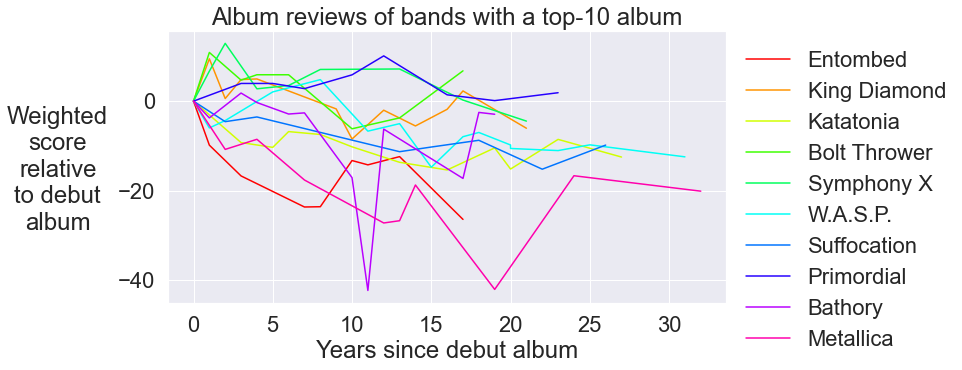

In [53]:
min_albums = 5
num_bands = 10
bands_album_counts = df_albums.groupby('band_name').apply(len)
bands_max_scores = df_albums.groupby('band_name')['review_weighted'].max()[bands_album_counts >= min_albums]
bands_top = bands_max_scores.sort_values(ascending=False).iloc[:num_bands].index
band_scores = {}
for band in bands_top:
    df_band = df_albums[df_albums['band_name'] == band].sort_values('year')
    band_scores[band] = (df_band['year'].values, df_band['review_weighted'].values)
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
cmap = plt.cm.hsv
ax.set_prop_cycle(color=[cmap(i) for i in np.linspace(0, 0.9, len(band_scores))])
for band, (years, scores) in band_scores.items():
    ax.plot(years - years.min(), scores - scores[0], label=band)
ax.set_title(f"Album reviews of bands with a top-{num_bands} album")
ax.set_xlabel("Years since debut album")
ax.set_ylabel("Weighted\nscore\nrelative\nto debut\nalbum", rotation=0, labelpad=60, y=0.25)
ax.legend(bbox_to_anchor=(1, 1))
plt.show()

## Global album trends

Now for a more comprehensive look at the history of metal, as told by the MA community.
We can see that the number of metal albums grew up until the late 2000's,
and has been in a gradual decline since.
The annual average of weighted-average scores (fourth plot)
peaks towards the end of the 80s, about the same time that many of those top bands
from above were releasing their most iconic albums.
As the metal scene saturated, the quality dropped,
with scores hitting a low point that coincides with the peak in number of albums.

An alternative explanation could be that nostalgia inflates reviewers' opinions of earlier albums,
especially in those bands above whose quality floundered over the years.
There's little that can be done to test this hypothesis since all of the reviews of early albums here are written with hindsight,
but maybe in a few more years we can take another look and see if review sentiment shifts upward
as 2000s bands become the new nostalgia.

Although album production has been in a bit of a Dark Age in the last few years,
and review rates for newer albums still trail behind those that have
been around for a while, records from the last few years are performing much better
than those from the 2000s and early 2010s.
The annual weighted average is almost back to matching that of albums from the 70s.

In [54]:
df_years = df[df.columns[df.columns.str.match('^(band_|album_|genre_)')]].groupby('album_year').first()
df_years['album_num'] = df.groupby(['album_year', 'album_name']).first().reset_index().groupby('album_year').apply(len)
df_years['review_avg'] = df.groupby('album_year')['review_score'].mean()
df_years['review_num'] = df.groupby('album_year').apply(len)
df_years.reset_index(inplace=True)
df_years.rename(columns={'album_year': 'year'}, inplace=True)
df_years['review_weighted'] = weighted_scores(df_years)

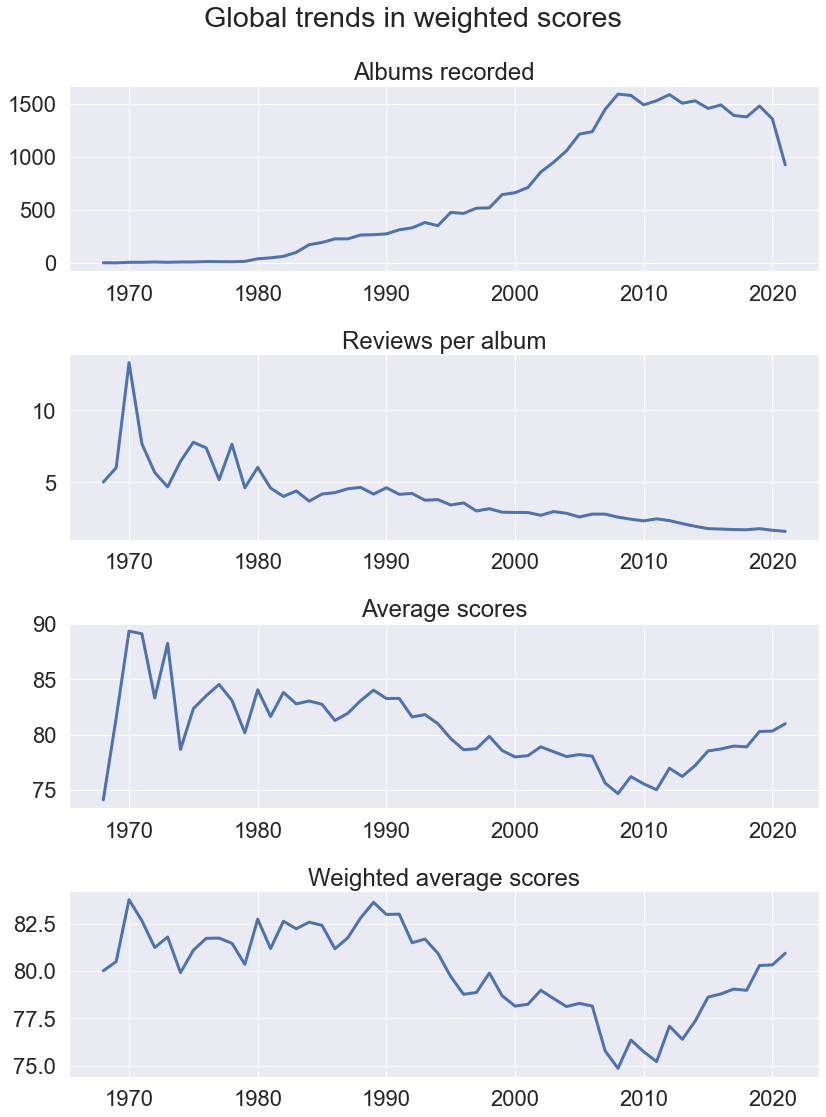

In [55]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(12, 16))
fig.subplots_adjust(hspace=0.3)
fig.suptitle("Global trends in weighted scores")
ax1.plot(df_years['year'], df_years['album_num'], lw=3)
ax2.plot(df_years['year'], df_years['review_num'] / df_years['album_num'], lw=3)
ax3.plot(df_years['year'], df_years['review_avg'], lw=3)
ax4.plot(df_years['year'], df_years['review_weighted'], lw=3)
ax1.set_title("Albums recorded")
ax2.set_title("Reviews per album")
ax3.set_title("Average scores")
ax4.set_title("Weighted average scores")
fig.tight_layout()
plt.show()

The number of metal albums released per year grew up until the late 2000's,
but has since plateaued.
The annual average of weighted-average scores (fourth plot)
stays quite high throughout the 70s and 80s,
about the same time that many of the all-time top bands
were releasing their most iconic albums.
As the metal scene saturated, quality dropped,
with scores hitting a low point coinciding with the peak in number of albums.
Albums from the past decade, however, have performed better,
with average just about returning to pre-90s levels,
giving fans reason to be optimistic about the direction that heavy metal is going.
Even the slump in album production in 2020-21 due to the pandemic has not
manifested in a drop in album quality, certainly a positive sign for the industry!
The number of reviews per album is still in decline,
but at least for albums of the past few years this is likely just due to recency bias.
We saw at the beginning that the rate of reviews submitted to MA hasn't actually dropped in recent years.

In [56]:
def padded_array(x, pad):
    return np.concatenate((np.ones(pad) * x[0], x, np.ones(pad) * x[-1]))

def smooth(x, kernel, w, pad):
    kernel /= kernel.sum()
    x_smooth = np.convolve(x, kernel, mode='same')
    std = np.sqrt(np.convolve((x - x_smooth)**2, kernel, mode='same'))
    if pad > 0:
        x_smooth = x_smooth[pad:-pad]
    if pad > 0:
        std = std[pad:-pad]
    return x_smooth, std

def gsmooth(x, w=1, pad='auto', kernel_threshold=1e-5):
    if w == 0:
        return x, np.zeros_like(x)
    if pad == 'auto':
        pad = w
    x_padded = padded_array(x, pad)
    kernel_x = np.linspace(-x.size, x.size, x_padded.size)
    sigma = w / (2 * np.sqrt(2 * np.log(2)))
    kernel = np.exp(-kernel_x**2 / (2 * sigma**2))
    kernel[kernel < kernel_threshold] = 0
    return smooth(x_padded, kernel, w, pad)

#### Yearly album output and review scores by genre

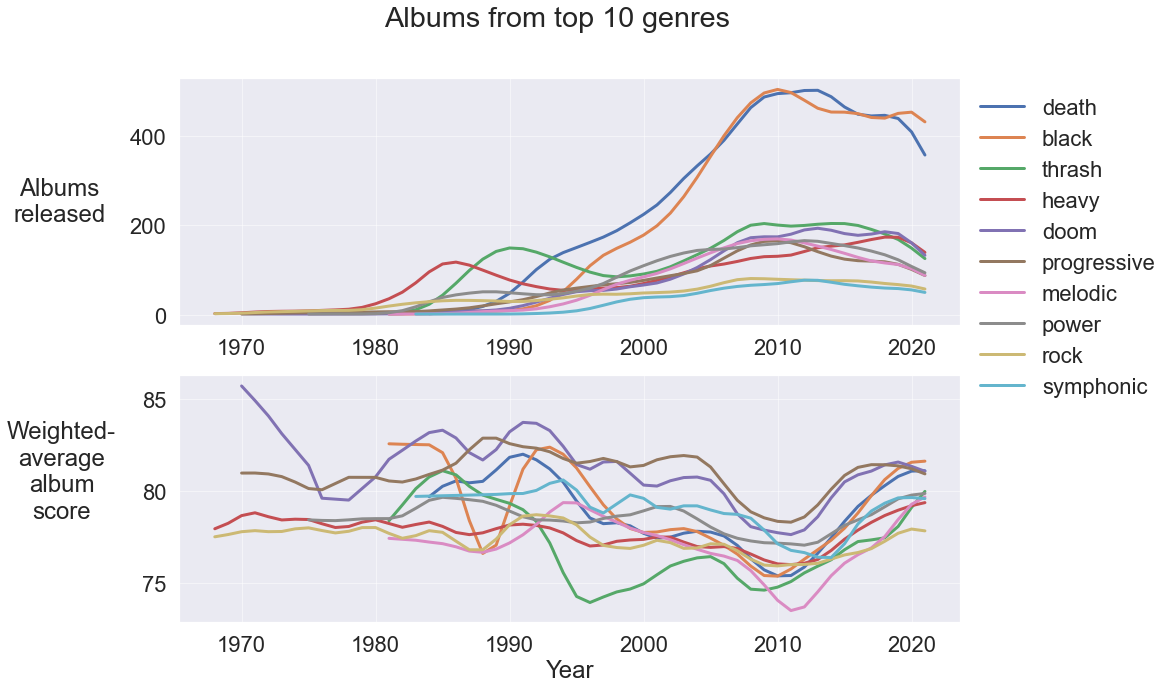

In [57]:
top_genre_cols = list(df_bands[['genre_' + g for g in genres]].sum().sort_values(ascending=False)[:10].index)

smoothing = 5
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 10))
fig.suptitle("Albums from top 10 genres")

for col_name in top_genre_cols:
    group = df_albums[df_albums[col_name] > 0].groupby('year')
    num_albums = group.apply(len)
    x1 = num_albums.index
    y1, _ = gsmooth(num_albums.values, smoothing)
    group_reviews = pd.concat((group['review_avg'].mean(), group['review_num'].sum()), axis=1)
    group_weighted_scores = weighted_scores(group_reviews)
    x2 = group_weighted_scores.index
    y2, _ = gsmooth(group_weighted_scores.values, smoothing)
    line, = ax1.plot(x1, y1, lw=3, label=col_name.replace('genre_', ''))
    ax2.plot(x2, y2, lw=3, color=line.get_color())

ax1.set_ylabel("Albums\nreleased", rotation=0, labelpad=70, y=0.4)
ax1.legend(bbox_to_anchor=(1, 1))
ax1.grid(alpha=0.5)

ax2.set_xlabel("Year")
ax2.set_ylabel("Weighted-\naverage\nalbum\nscore", rotation=0, labelpad=80, y=0.4)
ax2.grid(alpha=0.5)

Although most genres contributed to the rise of metal in the 2000s,
black and death metal dominated the trend.
Before then, it was heavy metal and thrash metal that ruled supreme,
spearheading the 80s upswing that brought heavy metal into the public spotlight.

Early doom metal (led by Black Sabbath) is very highly rated, and even more recent doom metal albums
continue to outperform material from other genres rather consistently.
Early black metal albums likewise had a high-scoring start, but have mostly converged towards
the overal average since then.
Death metal enjoyed its peak in the early nineties, followed by a long brutal decline throughout the 2000s.
Progressive rock/metal peaked twice, once in the late-80s wave (perhaps thanks to Rush),
and again the early 2000s as progressive metal started to take shape.
Recently it's been the most highly-rated genre after doom metal.

## Geographic trends

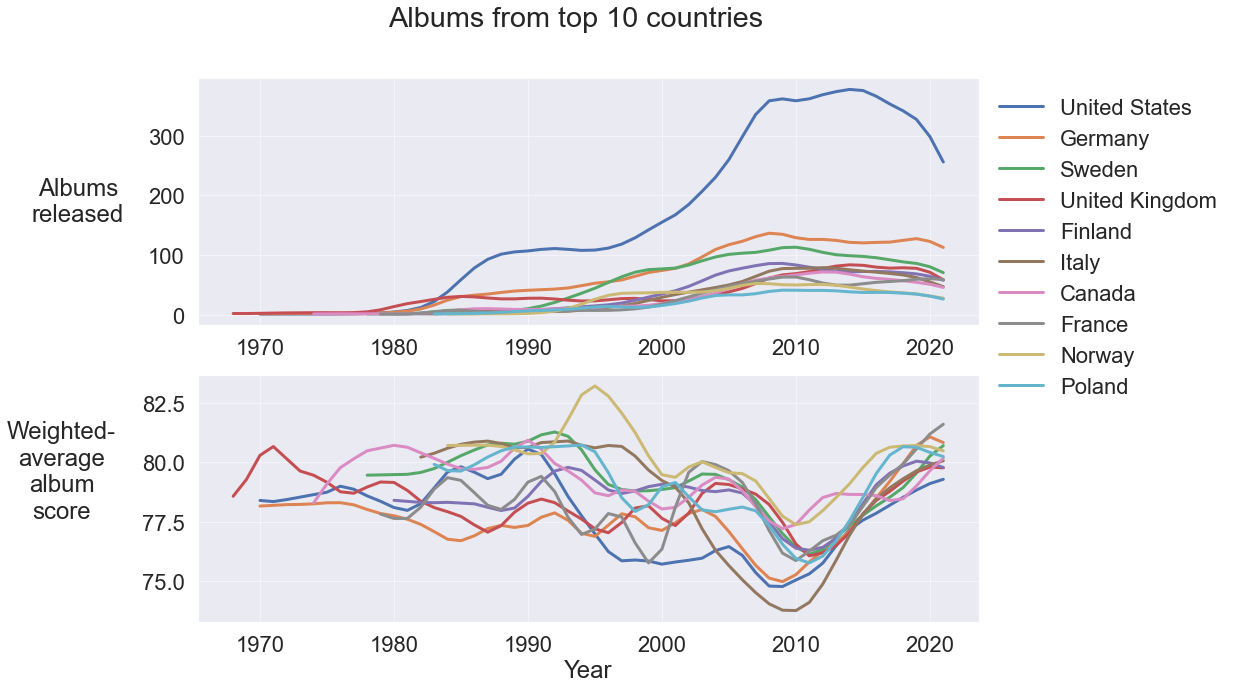

In [58]:
smoothing = 5
countries_albums = df_albums.groupby('band_country_of_origin').size()
countries = countries_albums.sort_values(ascending=False)[:10].index

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 10))
fig.suptitle("Albums from top 10 countries")

for country in countries:
    group = df_albums[df_albums['band_country_of_origin'] == country].groupby('year')
    num_albums = group.apply(len)
    x1 = num_albums.index
    y1, _ = gsmooth(num_albums.values, smoothing)
    group_reviews = pd.concat((group['review_avg'].mean(), group['review_num'].sum()), axis=1)
    group_weighted_scores = weighted_scores(group_reviews)
    x2 = group_weighted_scores.index
    y2, _ = gsmooth(group_weighted_scores.values, smoothing)
    line, = ax1.plot(x1, y1, lw=3, label=country)
    ax2.plot(x2, y2, lw=3, color=line.get_color())

ax1.set_ylabel("Albums\nreleased", rotation=0, labelpad=70, y=0.4)
ax1.legend(bbox_to_anchor=(1, 1))
ax1.grid(alpha=0.5)

ax2.set_xlabel("Year")
ax2.set_ylabel("Weighted-\naverage\nalbum\nscore", rotation=0, labelpad=80, y=0.4)
ax2.grid(alpha=0.5)

This plot shows just how consistently American bands have dominated the metal scence over the decades.
The U.K. was the first nation to pull ahead of others in producing metal albums,
but with the rise of the thrash era in the late 80s,
the U.S.A. took the lead and never lost it,
despite the Scandinavian black/death metal scene and the German power metal bands
pulling some attention back across the Atlantic.

Despite producing the most albums, the popularity of U.S. bands have never quite
broken beyond their Scandinavian counterparts.
After the initial peak in U.K. scores, the Scandinavians took over and continued
to put out the highest-rated albums throughout the decades.